In [2]:

import sys
import os
import io
import time
import string
import numpy as np
import pandas as pd
import pickle
import re
from collections import defaultdict
import random
import random
import csv
import sqlite3 as lite
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from collections import defaultdict
from IPython.display import clear_output


In [3]:
train_on_gpu = torch.cuda.is_available()
#train_on_gpu = False

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
train_set = "../res/train_set.tsv"
test_set = "../res/test_set.tsv"
valid_set = "../res/valid_set.tsv"
ft_vec = "../res/crawl-300d-2M-subword.vec"
glove50_path = "../res/GloveDict50.pkl"

model_path = "../res/mod3.pth"

max_q_len = 10
max_a_len = 100
embedding_len = 50
pad_char = '_'
batch_size=32
header_names = ["question","answer","label"]

translator = str.maketrans('', '', string.punctuation)

CUDA is available!  Training on GPU ...


In [4]:
def load_glove_vectors(fname):
    pickle_in = open(fname,"rb")
    _dict = pickle.load(pickle_in)
    return _dict

In [5]:
glove50 = load_glove_vectors(glove50_path)
supported_words = list(glove50.keys())
#print(supported_words[:100])

In [6]:
default_val = np.zeros(embedding_len)
glove = defaultdict(lambda: default_val,glove50)

In [7]:
class CustomDatasetFromCSV(Dataset):
    def __init__(self, csv_path, transform=None):
        _dataset = pd.read_csv(csv_path, sep='\t', header=None, names=header_names, encoding='utf8')
        self.labels = _dataset['label']
        self.questions = _dataset['question']
        self.answers = _dataset['answer']

    def __getitem__(self, index):
        q = self.questions.iloc[index]
        a = self.answers.iloc[index]
        q = q.lower()
        a = a.lower()
        q = q.translate(translator)
        a = a.translate(translator)
        
        tokens = set((q+" "+a).split(" "))
        unique_vals = [x for x in tokens if x not in supported_words]      
        
        
        q_list = np.zeros((max_q_len, (embedding_len+1)))
        a_list = np.zeros((max_a_len, (embedding_len+1)))
        
        
        q_words = q.split(" ")        
        if len(q_words) > max_q_len:
            q_words = q_words[:max_q_len]
        else:
            q_words = [pad_char]*(max_q_len - len(q_words) ) + q_words
            
        a_words = a.split(" ")
        if len(a_words) > max_a_len:
            a_words = a_words[:max_a_len]
        else:
            a_words = [pad_char]*(max_a_len - len(a_words) ) + a_words
        
        
        
        for i, word in enumerate(q_words):
            q_val = glove[word]
            if word not in unique_vals:
                q_val = np.append(q_val, 0)
            else:
                q_val = np.append(q_val, unique_vals.index(word))            
            q_list[i] = q_val
        
            
        for i, word in enumerate(a_words):
            a_val = glove[word]
            if word not in unique_vals:
                a_val = np.append(a_val, 0)
            else:
                a_val = np.append(a_val, unique_vals.index(word))            
            a_list[i] = a_val
        
        
        x = [q_list,a_list]
        y = self.labels.iloc[index]
        return x, y
    def __len__(self):
        return len(self.labels)

In [31]:

class W_RNN(nn.Module):

    def __init__(self, n_hidden=128, n_layers=3, drop_prob=0.2, lr=0.001):
        super(W_RNN,self).__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr

        self.lstm = nn.LSTM((embedding_len+1), n_hidden, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(n_hidden, (embedding_len+1))
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x, hidden):
        ''' Forward pass through the network.
            These inputs are x, and the hidden/cell state `hidden`. '''
        x = x.float()
        r_output, hidden = self.lstm(x, hidden)
        out = self.dropout(r_output)
         # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        #out = self.sigmoid(x)
        return out, hidden


    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())

        return hidden



In [37]:
class FC_OP(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        super(FC_OP, self).__init__()
        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        #print("Before ",x.size())
        x = F.sigmoid(x)
        #print("After ",x.size())
        return x
    

In [38]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.qNet = W_RNN()
        self.aNet = W_RNN()
        self.fcNet = FC_OP(input_size = ((embedding_len+1)*2),
                          output_size = 1,
                          hidden_layers = [128,128], 
                          drop_p = 0.2)

    def forward(self, questions, answers, q_hidden, a_hidden):
        q, q_hidden = self.qNet(questions, q_hidden)
        a, a_hidden = self.aNet(answers, a_hidden)
        #print(q.size())
        #print(a.size())
        ops = torch.cat((q, a), 1)                
        output = self.fcNet(ops)
        return output, q_hidden, a_hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        q_hidden = self.qNet.init_hidden(batch_size)
        a_hidden = self.aNet.init_hidden(batch_size)
        return q_hidden, a_hidden



In [39]:
#model loss and optimizers here
net = Model()
#print(net)

lr = 0.0001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

if train_on_gpu:
    net = net.cuda()

In [40]:
custom_data = CustomDatasetFromCSV(test_set)    
test_loader = torch.utils.data.DataLoader(dataset=custom_data, batch_size=32, shuffle=True)

custom_data = CustomDatasetFromCSV(train_set)    
train_loader = torch.utils.data.DataLoader(dataset=custom_data, batch_size=32, shuffle=True)

custom_data = CustomDatasetFromCSV(valid_set)    
valid_loader = torch.utils.data.DataLoader(dataset=custom_data, batch_size=32, shuffle=True)

In [71]:
# Use this for both test and validation set
def test(dataloader):
    dataset_loss = 0
    dataset_acc = 0
    net.eval()
    count = 0    
    batches_so_far = 0
    elements_seen = 0
    good_case = False
    gc_record =[]
    
    with torch.no_grad():
        for x, y in dataloader:            
            q = x[0]
            a = x[1]
            if train_on_gpu:
                q = q.cuda()
                a = a.cuda()
                y = y.cuda()                
            l = len(y)
            if l != batch_size:
                # last incomplete batch, skip over it.
                continue;
            batches_so_far += 1
            count += 1
            elements_seen += l
            q_hidden, a_hidden = net.init_hidden(batch_size)            
            output, q_hidden, a_hidden = net(questions = q, answers = a, q_hidden = q_hidden, a_hidden = a_hidden)
            output = output.flatten()
            loss = criterion(output, y.float())
            interpretation = (output>0.5).float()
            i_sum = interpretation.sum()
            if i_sum == 0 or i_sum == l:
                #print("!", end = "")
                pass
            else:
                good_case = True
                gc_record.append(i_sum)
                #print(interpretation)
                ## print("True Flag ", interpretation.sum())
            equals = interpretation == y.float()           
            dataset_loss += loss.item()
            dataset_acc += equals.sum()
            
        dataset_loss = dataset_loss/batches_so_far
        dataset_accuracy = dataset_acc.item()/elements_seen
        
        if good_case:
            print("!!!GOODCASE!!!\n",gc_record,"\n")
            gc_record = []
            good_case = False
        
    return dataset_loss, dataset_accuracy

In [52]:
def plot_this(d1, d2, name):
    plt.figure(name)
    lists1 = d1.items() # sorted by key, return a list of tuples
    lists2 = d2.items() # sorted by key, return a list of tuples
    x1, y1 = zip(*lists1) # unpack a list of pairs into two tuples
    x2, y2 = zip(*lists2) # unpack a list of pairs into two tuples
    plt.plot(x1, y1, label = "train")
    plt.plot(x2, y2, label = "valid")
    plt.show()
    

In [53]:
dtl = {}
dta = {}   
dvl = {}
dva = {}

lowest_loss = np.inf

In [78]:
def train(epoch=1, print_every=1, clip = 5):
    net.train()
    train_loss = 0;
    train_acc = 0;
    valid_loss = 0;
    valid_acc = 0;
    count = 0    
    
    dtl = {}
    dta = {}   
    dvl = {}
    dva = {}
    
    interrupted = False

    lowest_loss = np.inf
    
    for e in range(epoch):
        
        batches_so_far = 0
        elements_seen = 0
        for x, y in train_loader:            
            q = x[0]
            a = x[1]
            if train_on_gpu:
                q = q.cuda()
                a = a.cuda()
                y = y.cuda()                
            l = len(y)      
            if interrupted:
                interrupted = False
                print("Continue as usual again")
            
            if l != batch_size:
                print("Abrupt batch size for training, l = ", l)
                print("epoch ", e)
                print("count ", count)
                print("batches_so_far ", batches_so_far)
                print("elements_seen ", elements_seen)
                interrupted = True
                
                # last incomplete batch, skip over it.
                continue;
            elements_seen += l # not one, but l
            batches_so_far +=1
            count += 1            
            net.zero_grad()
            q_hidden, a_hidden = net.init_hidden(batch_size)            
            output, q_hidden, a_hidden = net(questions = q, answers = a, q_hidden = q_hidden, a_hidden = a_hidden)
            
            #output = output.flatten()
            #print("\n\n\noutput ",output.flatten())
            #print("\n\n\noutput ",output.size())
            #print("\ny.float() ",y.size() )
            y = y.view(batch_size, -1)
            #print("\ny.float() ",y.size() )
            #print("\nmodel path ",model_path )
            
            loss = criterion(output, y.float())
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()
            
            interpretation = (output>0.5).float()
            equals = interpretation == y.float()            
            train_loss += loss.item()
            train_acc += equals.sum()
            #print("\ninterpretation ",interpretation)
            #print("\ny.float() ",y.float() )
            #print("\ntrain ac",train_acc)
            #print("\elements_seen ",elements_seen)
            #print("\equals ",equals)
            #print("\sum ",equals.sum())
            
            if count%print_every == 0:
                # why counts are batch size and not int
                train_loss = train_loss/batches_so_far
                #print("\n1 train ac",train_acc)
                train_accuracy = train_acc.item()/elements_seen                
                #print("\n2 train ac",train_acc)
                
                # to save some time at initial training
                # calculate validation only after 1000 batches
                #if count > 200:
                valid_loss, valid_accuracy = test(valid_loader)
                #else:
                #valid_loss = train_loss
                #valid_accuracy = train_accuracy
                    
                clear_output(wait=True)
                print("Train Loss ", train_loss, "\tTrain Acc ", train_accuracy, "\nValid Loss", valid_loss, "\tValid Acc", valid_accuracy)
                if  valid_loss < lowest_loss:
                    lowest_loss = valid_loss
                    
                    torch.save(net.state_dict(),model_path)                
                net.train()                    
                dtl[count]= train_loss
                dvl[count]= valid_loss
                dta[count]= train_accuracy
                dva[count]= valid_accuracy
                plot_this(dtl, dvl, "Loss")
                plot_this(dta, dva, "Acc")
                
                batches_so_far = 0
                elements_seen = 0
                train_loss = 0;
                train_acc = 0;
                valid_loss = 0;
                valid_acc = 0;
                
                #if count == 5: break
                
            #break;

Train Loss  0.6841041797399521 	Train Acc  0.56125 
Valid Loss 0.6852122085695048 	Valid Acc 0.5570133587786259


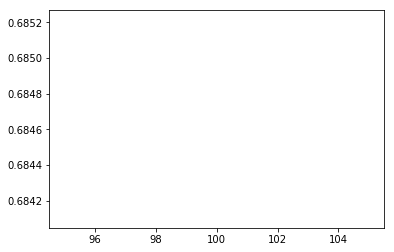

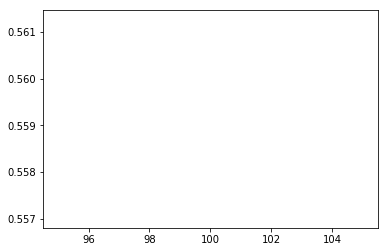

In [ ]:
train(epoch = 10, print_every = 100)

In [74]:
# simple load
state_dict_1 = torch.load(model_path)

# simple load into model
net.load_state_dict(state_dict_1)
if train_on_gpu:
    net = net.cuda()

In [ ]:
print(list(net.parameters()))

In [ ]:
test_loss, test_accuracy = test(test_loader)

#clear_output(wait=True)
print("test_loss ", test_loss, "\ttest_accuracy ", test_accuracy)